In [2]:
from models.genre_classification.sota_models.CNNSA import CNNSA
import torchaudio
from torchaudio.functional import resample
import torch
from typing import List
import numpy as np
from utils.genre_classification import evaluate, executor, feature_preparator
from utils.genre_classification.plot_metrics import plot_metrics
from utils.genre_classification import plot_confusion_matrix
from torch import nn

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
BATCH_SIZE = 64
NUM_CLASSES = 8
DEVICE = torch.device('cuda')

In [5]:
%%time

def raw_audio_slicer(features):
    time_len = features.shape[1]
    slice_len = 22050 * 5  # 5 минут

    min_idx = np.random.randint(time_len - slice_len)

    return torch.index_select(features, 1, torch.tensor(range(min_idx, min_idx + slice_len)))

def transform(path: List[str]):
    waveform, sample_rate = torchaudio.load(path[0], normalize=True)
    waveform = waveform.mean(dim=0, keepdim=True)
    waveform = resample(waveform, orig_freq=sample_rate, new_freq=22050)
    waveform = raw_audio_slicer(waveform)

    return waveform[0]

train_data_loader, val_data_loader, test_data_loader, idx_to_label = feature_preparator(
    'features/genre_classification/external-nn.p',
    BATCH_SIZE,
    normalize=False,
    external=True,
    transform=transform
)

def transform_idx_to_label(x):
    return idx_to_label[x]

CPU times: user 39.2 ms, sys: 5.68 ms, total: 44.8 ms
Wall time: 44.9 ms


In [6]:
next(iter(train_data_loader))[0].shape

torch.Size([64, 110250])

In [11]:
cnnsa_model = CNNSA(sample_rate=22050, n_class=NUM_CLASSES, f_max=11025).to(DEVICE)
train_progress, val_progress = executor(DEVICE, cnnsa_model, train_dataloader = train_data_loader, val_dataloader=val_data_loader, epochs=15, learning_rate=0.001, weight_decay=0.1, evaluate_per_iteration=10, early_stop_after=(5,  0.001))

plot_metrics(train_progress, val_progress, metrics = ['loss', 'accuracy'])

/home/araxal/.local/lib/python3.10/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(
  0%|          | 0/15 [00:02<?, ?it/s]


RuntimeError: stft input and window must be on the same device but got self on cpu and window on cuda:0

In [ ]:
test_loss, test_accuracy, (test_pred, test_true) = evaluate(DEVICE, cnnsa_model, test_data_loader, criterion=nn.CrossEntropyLoss(), return_pred=True)

plot_confusion_matrix(test_true, test_pred, idx_to_label, transform_idx_to_label)

  7%|▋         | 1/15 [28:11<6:34:39, 1691.36s/it]

2.022881815351289 2.0682089554000007


 13%|█▎        | 2/15 [56:30<6:07:29, 1696.10s/it]

1.995180236882177 2.0323977291858695


 20%|██        | 3/15 [1:24:34<5:38:05, 1690.46s/it]

1.999033733071952 2.0313576959794566


 27%|██▋       | 4/15 [1:52:34<5:09:11, 1686.45s/it]

2.0098906311495552 2.0409953283824125


 33%|███▎      | 5/15 [2:20:44<4:41:15, 1687.57s/it]

2.023226554640408 2.04952436108743


 40%|████      | 6/15 [2:48:44<4:12:44, 1684.94s/it]

2.0331938677820665 2.056821582504132


 47%|████▋     | 7/15 [3:16:43<3:44:24, 1683.11s/it]

2.046438592055748 2.06113833491154


 47%|████▋     | 7/15 [3:44:40<4:16:46, 1925.85s/it]

2.0575986549772067 2.067360742300886
Early stop!


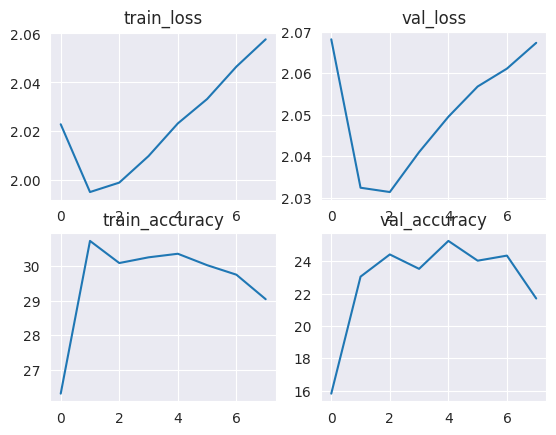

In [9]:
from models.genre_classification.sota_models.HarmonicCNN import HarmonicCNN

harmonic_cnn_model = HarmonicCNN(sample_rate=22050, n_class=NUM_CLASSES, f_max=11025, n_channels=16).to(DEVICE)
train_progress, val_progress = executor(DEVICE, harmonic_cnn_model, train_dataloader = train_data_loader, val_dataloader=val_data_loader, epochs=15, learning_rate=0.001, weight_decay=0.1, evaluate_per_iteration=10, early_stop_after=(5,  0.001), print_metrics=True)

plot_metrics(train_progress, val_progress, metrics = ['loss', 'accuracy'])

In [8]:
import torch
import gc
torch.cuda.empty_cache() # PyTorch thing
gc.collect()

1304